In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchmetrics.classification import MulticlassAccuracy
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, Stratified
import numpy as np

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import BertForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
config = AutoConfig.from_pretrained("j-hartmann/emotion-english-distilroberta-base", 
                                    num_labels=5, 
                                    hidden_dropout_prob=0.1,
                                    attention_probs_dropout_prob=0.1, return_dict=True)
model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base", 
                                                           config=config,
                                                           ignore_mismatched_sizes=True)

/root/SSNE-Pawel/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
data = pd.read_csv("../data/train_data.csv")
data["label"] = data["rating"]
data.rename(columns={"review":"text"}, inplace=True)
data.drop('rating', axis=1, inplace=True)
train_data, val_data = train_test_split(data, test_size=0.1, random_state=42)
print(data)

                                                    text  label
0      location not palace excellent hotel booke dthe...      4
1      respite definitely not place stay looking ultr...      3
2      stunning truly memorable spot right beach nusa...      4
3      solid business hotel near embassy stayed hotel...      3
4      nice place make sure lock money warning money ...      3
...                                                  ...    ...
16387  great base explore new york stayed 4 nights en...      4
16388  wonderful advert paris wonderful introduction ...      4
16389  ideal relaxing holdiay rachel jay green liverp...      3
16390  watch food, husband went resort 4 nights chris...      2
16391  fantastic hotel central barcelona family just ...      4

[16392 rows x 2 columns]


In [6]:
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

In [24]:
len(val_data["label"])

1640

In [7]:
def create_data_loader(encodings, labels):
    dataset = TensorDataset(encodings["input_ids"], encodings["attention_mask"], torch.tensor(labels.values))
    loader = DataLoader(dataset, batch_size=16, shuffle=True)
    return loader

In [8]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [9]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [10]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        target = self.targets[idx]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            # max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(target, dtype=torch.long)
        }

In [11]:
train_dataset = ReviewDataset(
    reviews=train_data['text'].to_numpy(),
    targets=train_data['label'].to_numpy(),
    tokenizer=tokenizer,
)

test_dataset = ReviewDataset(
    reviews=val_data['text'].to_numpy(),
    targets=val_data['label'].to_numpy(),
    tokenizer=tokenizer,
)

In [12]:
from datetime import datetime
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = f"./results_{now}"
training_args = TrainingArguments(
    output_dir="../models/results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
    
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

/root/SSNE-Pawel/.venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Tradycyjne podejście bez walidacji krzyzowej

In [128]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

Model ma tendencje do przetrenowywania, więc naturalnym krokiem będzie dobranie odpowiedniej strategi niwelującej przetrenowanie. W naszym przypadku zastosujemy skrośną walidacje.

# Walidacja skrośna

In [14]:
from sklearn.model_selection import KFold
import numpy as np

n_splits = 10
kf = KFold(n_splits=n_splits)

reviews = train_data['text'].to_numpy()
targets = train_data['label'].to_numpy()

In [15]:
for train_index, val_index in kf.split(reviews):
    train_reviews, val_reviews = reviews[train_index], reviews[val_index]
    train_targets, val_targets = targets[train_index], targets[val_index]

    train_dataset = ReviewDataset(train_reviews, train_targets, tokenizer, 128)
    val_dataset = ReviewDataset(val_reviews, val_targets, tokenizer, 128)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )
    trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.805672,0.647696,0.575965,0.583624,0.578070
2,0.857400,0.782911,0.660569,0.597669,0.615448,0.591337
3,0.712000,0.783300,0.668699,0.592128,0.607585,0.587453
4,0.630900,0.794953,0.668699,0.610219,0.609189,0.611773
5,0.582600,0.805128,0.672087,0.606198,0.612250,0.603020


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.549952,0.765583,0.711007,0.709899,0.726720
2,0.569500,0.527761,0.772358,0.724946,0.739545,0.714292
3,0.455500,0.534189,0.790650,0.758230,0.765205,0.753987
4,0.388700,0.548305,0.790650,0.760653,0.764960,0.757225
5,0.366600,0.545580,0.789295,0.757801,0.763352,0.752834


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.348728,0.871186,0.868748,0.878196,0.860574
2,0.483700,0.358215,0.854915,0.849485,0.855168,0.847790
3,0.390300,0.358081,0.869831,0.861023,0.862961,0.860438
4,0.323500,0.354665,0.865085,0.857516,0.864430,0.851218
5,0.258800,0.353827,0.875254,0.871269,0.873888,0.869313


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.168454,0.943729,0.937055,0.928626,0.946808
2,0.218700,0.139871,0.947119,0.941280,0.945818,0.937376
3,0.176000,0.153678,0.952542,0.950456,0.954535,0.947482
4,0.135700,0.121471,0.960000,0.956687,0.959991,0.953786
5,0.133000,0.121851,0.960678,0.957756,0.959463,0.956515


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.104087,0.960000,0.961966,0.967207,0.959019
2,0.135700,0.051345,0.981017,0.977571,0.979747,0.975800
3,0.106100,0.089372,0.970169,0.973098,0.975023,0.972505
4,0.074000,0.025264,0.991864,0.994034,0.995522,0.992586
5,0.087600,0.018861,0.993220,0.994773,0.994630,0.994939


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.094406,0.966102,0.967037,0.972988,0.961675
2,0.118000,0.054872,0.985085,0.985141,0.987223,0.983130
3,0.093300,0.059220,0.983051,0.980229,0.984212,0.976653
4,0.053800,0.043497,0.990508,0.988435,0.987799,0.989184
5,0.059200,0.027694,0.991864,0.991063,0.990718,0.991422


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.040235,0.987119,0.986318,0.984143,0.988798
2,0.100700,0.052885,0.984407,0.986790,0.983087,0.990841
3,0.071000,0.041052,0.987119,0.985691,0.986089,0.985427
4,0.045600,0.043328,0.988475,0.986680,0.983207,0.990304
5,0.043900,0.017471,0.993898,0.992593,0.991459,0.993845


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.045160,0.987119,0.983594,0.982828,0.984477
2,0.115500,0.031962,0.988475,0.990291,0.989094,0.991567
3,0.053600,0.019188,0.993898,0.992187,0.993361,0.991165
4,0.035300,0.011188,0.996610,0.994610,0.994610,0.994610
5,0.035200,0.008845,0.997288,0.996257,0.996502,0.996029


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.068416,0.981695,0.983625,0.985628,0.982069
2,0.098300,0.032772,0.992542,0.992375,0.991132,0.993663
3,0.048200,0.027192,0.993220,0.991858,0.991038,0.992739
4,0.035100,0.023014,0.995932,0.995988,0.996020,0.995977
5,0.026800,0.018810,0.996610,0.997623,0.997838,0.997416


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.071473,0.980339,0.977182,0.976756,0.977951
2,0.084000,0.038516,0.986441,0.987414,0.990691,0.984470
3,0.056200,0.017780,0.993898,0.995108,0.994280,0.995956
4,0.035000,0.008918,0.997288,0.997114,0.997067,0.997184
5,0.021800,0.006926,0.997966,0.996156,0.995585,0.996789


In [18]:
predictions = trainer.predict(val_dataset)
predictions_argmax = torch.argmax(torch.tensor(predictions.predictions), dim=1)

In [25]:
predictions = trainer.predict(test_dataset)
predictions_argmax = torch.argmax(torch.tensor(predictions.predictions), dim=1)

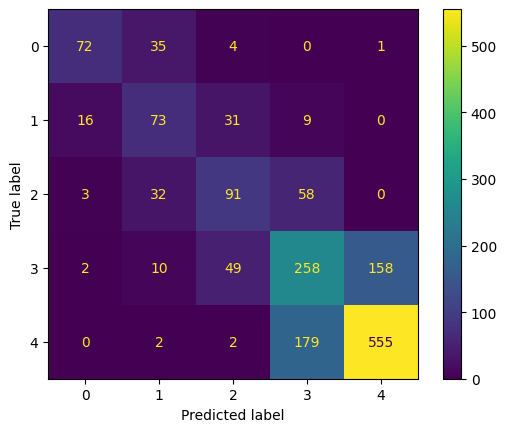

In [27]:
confusion_matrix_train = confusion_matrix(test_dataset.targets , predictions_argmax)
ConfusionMatrixDisplay(confusion_matrix_train).plot()
plt.show()

In [34]:
mca_eval = MulticlassAccuracy(num_classes=5, average=None)
mca_average = MulticlassAccuracy(num_classes=5, average='micro')

In [32]:
mca_eval(predictions_argmax, torch.tensor(test_dataset.targets))

tensor([0.6429, 0.5659, 0.4946, 0.5409, 0.7520])

In [35]:
mca_average(predictions_argmax, torch.tensor(test_dataset.targets))

tensor(0.6396)

Walidacja skrośna pozwala na ograniczenie przetrenowania, ale w obecnej formie nie neguje problemów związanych z nierówną dystrybucją danych.

# Walidacja skrośna z wykorzystaniem podziału z równą dystrybucją klas w poszczególnych foldach i funkcji strat z wagami